<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/fuzzyLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy -q

0.8055555555555557


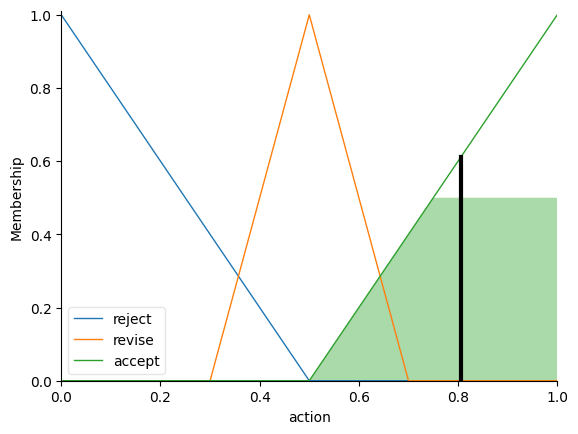

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define linguistic variables for LLM confidence and sentiment score
confidence = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'confidence')
sentiment = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'sentiment')
action = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'action')

# Define membership functions for each variable
confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['medium'] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence['high'] = fuzz.trimf(confidence.universe, [0.5, 1, 1])

sentiment['negative'] = fuzz.trimf(sentiment.universe, [-1, -1, 0])
sentiment['neutral'] = fuzz.trimf(sentiment.universe, [-0.5, 0, 0.5])
sentiment['positive'] = fuzz.trimf(sentiment.universe, [0, 1, 1])

action['reject'] = fuzz.trimf(action.universe, [0, 0, 0.5])
action['revise'] = fuzz.trimf(action.universe, [0.3, 0.5, 0.7])
action['accept'] = fuzz.trimf(action.universe, [0.5, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(confidence['low'] & sentiment['negative'], action['reject'])
rule2 = ctrl.Rule(confidence['medium'] & sentiment['negative'], action['revise'])
rule3 = ctrl.Rule(confidence['high'] & sentiment['negative'], action['revise'])
rule4 = ctrl.Rule(confidence['low'] & sentiment['neutral'], action['revise'])
rule5 = ctrl.Rule(confidence['medium'] & sentiment['neutral'], action['revise'])
rule6 = ctrl.Rule(confidence['high'] & sentiment['neutral'], action['accept'])
rule7 = ctrl.Rule(confidence['low'] & sentiment['positive'], action['revise'])
rule8 = ctrl.Rule(confidence['medium'] & sentiment['positive'], action['accept'])
rule9 = ctrl.Rule(confidence['high'] & sentiment['positive'], action['accept'])

# Create and simulate the control system
action_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
action_sim = ctrl.ControlSystemSimulation(action_ctrl)

# Example usage:
# Assume LLM generates text with confidence 0.6 and sentiment score 0.8
action_sim.input['confidence'] = 0.6
action_sim.input['sentiment'] = 0.8
action_sim.compute()

# Print the output (action to take)
print(action_sim.output['action'])
action.view(sim=action_sim)

In [ ]:
import logging
import numpy as np
import torch
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Hugging Face model id
model_id = "mistralai/Mistral-7B-Instruct-v0.1"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    # attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.padding_side = "right"  # to prevent warnings

# We redefine the pad_token and pad_token_id with out of vocabulary token (unk_token)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id = tokenizer.unk_token_id

Prompt:  Once upon a time, in a land far away
0.8062759053228621


Generated Text: Once upon a time, in a land far away… Oh, wait. That’s how fairy tales begin. Let me adjust that.

In a galaxy far, far away, there was a planet called Earth. Now, Earth wasn’t like the other planets in the galaxy.
Action Taken: accept




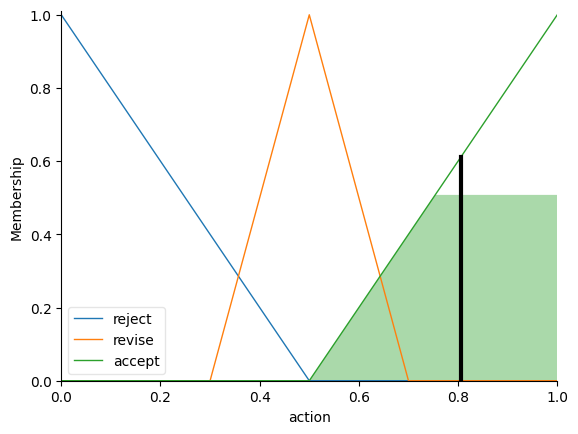

In [18]:
model.generation_config.pad_token_id = tokenizer.pad_token_id

# Define linguistic variables for LLM confidence and sentiment score
confidence = ctrl.Antecedent(np.arange(0, 1.1, 0.1), "confidence")
sentiment = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), "sentiment")
action = ctrl.Consequent(np.arange(0, 1.1, 0.1), "action")

# Define membership functions for each variable
confidence["low"] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence["medium"] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence["high"] = fuzz.trimf(confidence.universe, [0.5, 1, 1])

sentiment["negative"] = fuzz.trimf(sentiment.universe, [-1, -1, 0])
sentiment["neutral"] = fuzz.trimf(sentiment.universe, [-0.5, 0, 0.5])
sentiment["positive"] = fuzz.trimf(sentiment.universe, [0, 1, 1])

action["reject"] = fuzz.trimf(action.universe, [0, 0, 0.5])
action["revise"] = fuzz.trimf(action.universe, [0.3, 0.5, 0.7])
action["accept"] = fuzz.trimf(action.universe, [0.5, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(confidence["low"] & sentiment["negative"], action["reject"])
rule2 = ctrl.Rule(confidence["medium"] & sentiment["negative"], action["revise"])
rule3 = ctrl.Rule(confidence["high"] & sentiment["negative"], action["revise"])
rule4 = ctrl.Rule(confidence["low"] & sentiment["neutral"], action["revise"])
rule5 = ctrl.Rule(confidence["medium"] & sentiment["neutral"], action["revise"])
rule6 = ctrl.Rule(confidence["high"] & sentiment["neutral"], action["accept"])
rule7 = ctrl.Rule(confidence["low"] & sentiment["positive"], action["revise"])
rule8 = ctrl.Rule(confidence["medium"] & sentiment["positive"], action["accept"])
rule9 = ctrl.Rule(confidence["high"] & sentiment["positive"], action["accept"])

# Create and simulate the control system
action_ctrl = ctrl.ControlSystem(
    [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]
)


action_sim = ctrl.ControlSystemSimulation(action_ctrl)



def estimate_confidence(text, model, tokenizer):
    """Estimates the confidence score of the generated text using token probabilities.

    Args:
      text: The generated text.
      model: The Mistral language model.
      tokenizer: The Mistral tokenizer.

    Returns:
      A float representing the confidence score (between 0 and 1).
    """
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)  # Remove labels argument
    logits = outputs.logits[:, :-1, :]  # Exclude logits for the last token
    probabilities = torch.softmax(logits, dim=-1)
    # Calculate the average probability of the generated tokens
    avg_prob = torch.mean(torch.max(probabilities, dim=-1).values).item()
    return avg_prob


def analyze_sentiment(text):
    """Analyzes the sentiment of the generated text.

    (Replace this with your actual sentiment analysis implementation)

    Args:
      text: The generated text.

    Returns:
      A float representing the sentiment score (between -1 and 1).
    """
    # Placeholder implementation: returns a random sentiment score
    return np.random.uniform(-1, 1)


def generate_text(prompt, confidence_threshold=0.8, max_new_tokens=50):
    """Generates text using the Mistral 7B model and evaluates it with a FIS.

    Args:
      prompt: The input prompt for text generation.
      confidence_threshold: The minimum confidence score for accepting text.
      max_new_tokens: The maximum number of tokens to generate.

    Returns:
      A tuple containing the generated text and the action taken
      (accept, revise, or reject).
    """

    inputs = tokenizer(prompt, return_tensors="pt")
    # Use GenerationConfig for text generation parameters
    generation_config = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=True)
    outputs = model.generate(**inputs, generation_config=generation_config)

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    confidence_score = estimate_confidence(generated_text, model, tokenizer)
    sentiment_score = analyze_sentiment(generated_text)

    action_sim.input["confidence"] = confidence_score
    action_sim.input["sentiment"] = sentiment_score
    action_sim.compute()

    # Print the output (action to take)
    print(action_sim.output["action"])
    action.view(sim=action_sim)  # Display the FIS output graphically

    action_taken = "accept"  # Default action
    if action_sim.output["action"] < 0.5:
        action_taken = "reject"
    elif action_sim.output["action"] < 0.8:
        action_taken = "revise"

    return generated_text, action_taken


# Example usage:
prompt = "Once upon a time, in a land far away"
print('Prompt: ',prompt)
generated_text, action_taken = generate_text(prompt)
print('\n')
print("Generated Text:", generated_text)
print("Action Taken:", action_taken)
print('\n')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.








Prompt:  Once upon a time, in a land far away
0.8090950868983957


Generated Text: Once upon a time, in a land far away, a kind and gentle king ruled over a beautiful kingdom. The kingdom was prosperous and full of happiness, and the people lived in peace and harmony with each other and with their surroundings.

The king was very wise, and he always made
Action Taken: accept




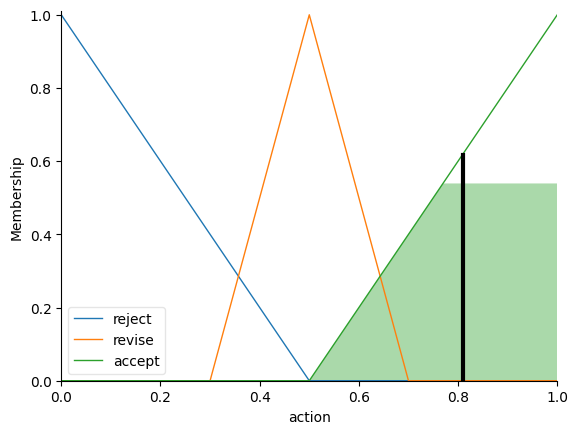

In [1]:
import logging
import numpy as np
import torch
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Suppress the warning about past_key_values
logging.getLogger("transformers.generation_utils").setLevel(logging.ERROR)


import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Hugging Face model id
model_id = "mistralai/Mistral-7B-Instruct-v0.1"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(model_id,use_fast=True)
tokenizer.padding_side = 'right' # to prevent warnings

# We redefine the pad_token and pad_token_id with out of vocabulary token (unk_token)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id = tokenizer.unk_token_id


#tokenizer.pad_token_id = tokenizer.eos_token_id  # Set pad_token_id to eos_token_id
# or
tokenizer.pad_token = "<PAD>"  # Add a new pad token
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids("<PAD>")


# Define linguistic variables for LLM confidence and sentiment score
confidence = ctrl.Antecedent(np.arange(0, 1.1, 0.1), "confidence")
sentiment = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), "sentiment")
action = ctrl.Consequent(np.arange(0, 1.1, 0.1), "action")

# Define membership functions for each variable
confidence["low"] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence["medium"] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence["high"] = fuzz.trimf(confidence.universe, [0.5, 1, 1])

sentiment["negative"] = fuzz.trimf(sentiment.universe, [-1, -1, 0])
sentiment["neutral"] = fuzz.trimf(sentiment.universe, [-0.5, 0, 0.5])
sentiment["positive"] = fuzz.trimf(sentiment.universe, [0, 1, 1])

action["reject"] = fuzz.trimf(action.universe, [0, 0, 0.5])
action["revise"] = fuzz.trimf(action.universe, [0.3, 0.5, 0.7])
action["accept"] = fuzz.trimf(action.universe, [0.5, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(confidence["low"] & sentiment["negative"], action["reject"])
rule2 = ctrl.Rule(confidence["medium"] & sentiment["negative"], action["revise"])
rule3 = ctrl.Rule(confidence["high"] & sentiment["negative"], action["revise"])
rule4 = ctrl.Rule(confidence["low"] & sentiment["neutral"], action["revise"])
rule5 = ctrl.Rule(confidence["medium"] & sentiment["neutral"], action["revise"])
rule6 = ctrl.Rule(confidence["high"] & sentiment["neutral"], action["accept"])
rule7 = ctrl.Rule(confidence["low"] & sentiment["positive"], action["revise"])
rule8 = ctrl.Rule(confidence["medium"] & sentiment["positive"], action["accept"])
rule9 = ctrl.Rule(confidence["high"] & sentiment["positive"], action["accept"])

# Create and simulate the control system
action_ctrl = ctrl.ControlSystem(
    [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]
)

print('\n')
action_sim = ctrl.ControlSystemSimulation(action_ctrl)
print('\n')


def estimate_confidence(text, model, tokenizer):
    """Estimates the confidence score of the generated text using token probabilities.

    Args:
      text: The generated text.
      model: The Mistral language model.
      tokenizer: The Mistral tokenizer.

    Returns:
      A float representing the confidence score (between 0 and 1).
    """
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)  # Remove labels argument
    logits = outputs.logits[:, :-1, :]  # Exclude logits for the last token
    probabilities = torch.softmax(logits, dim=-1)
    # Calculate the average probability of the generated tokens
    avg_prob = torch.mean(torch.max(probabilities, dim=-1).values).item()
    return avg_prob


def analyze_sentiment(text):
    """Analyzes the sentiment of the generated text.

    (Replace this with your actual sentiment analysis implementation)

    Args:
      text: The generated text.

    Returns:
      A float representing the sentiment score (between -1 and 1).
    """
    # Placeholder implementation: returns a random sentiment score
    return np.random.uniform(-1, 1)


def generate_text(prompt, confidence_threshold=0.8, max_new_tokens=50):
    """Generates text using the Mistral 7B model and evaluates it with a FIS.

    Args:
      prompt: The input prompt for text generation.
      confidence_threshold: The minimum confidence score for accepting text.
      max_new_tokens: The maximum number of tokens to generate.

    Returns:
      A tuple containing the generated text and the action taken
      (accept, revise, or reject).
    """

    inputs = tokenizer(prompt, return_tensors="pt")
    # Use GenerationConfig for text generation parameters
    generation_config = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=True)
    outputs = model.generate(**inputs, generation_config=generation_config)

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    confidence_score = estimate_confidence(generated_text, model, tokenizer)
    sentiment_score = analyze_sentiment(generated_text)

    action_sim.input["confidence"] = confidence_score
    action_sim.input["sentiment"] = sentiment_score
    action_sim.compute()

    # Print the output (action to take)
    print(action_sim.output["action"])
    action.view(sim=action_sim)  # Display the FIS output graphically

    action_taken = "accept"  # Default action
    if action_sim.output["action"] < 0.5:
        action_taken = "reject"
    elif action_sim.output["action"] < 0.8:
        action_taken = "revise"

    return generated_text, action_taken


# Example usage:
print('\n')
prompt = "Once upon a time, in a land far away"
print('Prompt: ',prompt)
generated_text, action_taken = generate_text(prompt)
print('\n')
print("Generated Text:", generated_text)
print("Action Taken:", action_taken)
print('\n')